##  This jupyter notebook converts  the JSON file from [Labelbox](https://www.labelbox.com/) to color images and 2-D numpy array of segmentation of each scene

In [1]:
import os
import json
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Define class numbers and colors

In [2]:
segment_class_no = {
    "road":0,
    "crosswalk":1,
    "sidewalk":2, 
    "other": 3
}

segment_class_color = {
    0: [255, 0, 0],
    1: [0, 204, 0],
    2: [255, 255, 0], 
    3: [255,0,255]
}
    

In [3]:
# Covert points of polygon to np arrary foramt
def dict_to_list(points):
    new_points = []
    for point in points:
        pt = [point['x'], point['y']]
        new_points.append(pt)
    return np.array(new_points, dtype = np.int32)


# K-NN algorithm that fills up the empty pixels at the bundary among the different classes of segmentation
def knn_fill_empty(img, radius):
    def points_in_circle_np(radius, x0=0, y0=0, ):
        x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
        y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
        x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
        for x, y in zip(x_[x], y_[y]):
            yield x, y
        
    h, w = img.shape
    for i in range(0, h):
        for j in range(0, w):
            if img[i][j] == -1:
                votes = {0:0, 1:0, 2:0, 3:0}
                all_pixels = points_in_circle_np(10, j, i)
                for x, y in all_pixels:
                    if x < w and x >= 0 and y < h and y >= 0:
                        if img[y][x] != -1:
                            votes[img[y][x]] += 1
                sorted_by_value = sorted(votes.items(), key=lambda kv: kv[1])
                img[i][j] = sorted_by_value[-1][0]
                
# Conver class number to color image                
def convert_to_color_img(img):
    h, w = img.shape
    new_img = np.zeros((h,w, 3))
    for i in range(0, h):
        for j in range(0, w):
            color = np.array(segment_class_color[int(img[i][j])])
            new_img[i][j] = color
    return new_img

### Main 

In [4]:

# Input parameters 
output_folder = "segmentation_output"  # output folder path
path_json = "./segmentation_meta_labelbox.json" # JSON file path
img_w = 3820 # image width
img_h = 2160 # image height


if not os.path.isdir(output_folder):
    os.mkdir(output_folder)
    
with open(path_json) as json_file:
    meta = json.load(json_file)

for scene in meta:
    if "old" not in scene["External ID"]:
        name = scene["External ID"][:-11]
        print("Processing {}.....".format(name))
        label = scene["Label"]
        polygons = {k: [ dict_to_list(geo['geometry']) for geo in v] for k,v in label.items()}
        img = np.empty((img_h, img_w))
        img.fill(-1)
        for k, v in polygons.items():
            cv2.fillPoly(img, v, segment_class_no[k])
        # KNN fill the gap between each segment
        knn_fill_empty(img, 25)
        new_img = convert_to_color_img(img)
        img.astype("uint8")
        new_img.astype("uint8")
        
        # Save segmentation in 2-D np array
        np.save(output_folder + "/" + name + "_cls"+".npy", img)
        # Save to image
        cv2.imwrite(output_folder + "/" + name + "_color" + ".jpg", new_img)
    
    

Processing Morges_Avenue_de_la_Gotta_4.....
Processing Morges_Avenue_de_la_Gotta_3.....
Processing Morges_Avenue_de_la_Gotta_2.....
Processing Morges_Avenue_de_la_Gotta_1.....
Processing Echabdens_Route_de_la_Gare_2.....
Processing Echabdens_Route_de_la_Gare_4.....
Processing Echabdens_Route_de_la_Gare_3.....
Processing Echabdens_Route_de_la_Gare_1.....
Processing EPFL_Route_Cantonale_31_2.....
Processing EPFL_Route_Cantonale_31_1.....
Processing Echabdens_Route_de_la_Gare_5.....
Processing Ecublens_Route_de_la_Pierre_2.....
Processing Echabdens_Route_de_la_Gare_2.....
Processing Morges_Avenue_de_la_Gotta_5.....
Processing Ecublens_Route_de_la_Pierre_1.....


### Example of the image of  "EPFL_Route_Cantonale_31_1"


Ecublens_Route_de_la_Pierre_1


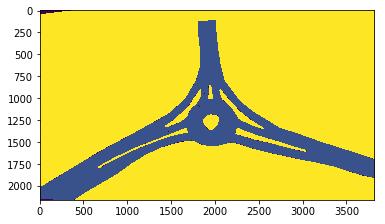

In [5]:
with open("./segmentation_meta_labelbox.json") as json_file:
    meta = json.load(json_file)
scene = meta[-1]
print(scene["External ID"][:-11])
label = scene["Label"]
polygons = {k: [ dict_to_list(geo['geometry']) for geo in v] for k,v in label.items()}

img = np.empty((2160, 3820))
img.fill(-1)
for k, v in polygons.items():
    cv2.fillPoly(img, v, segment_class_no[k])
plt.imshow(img)

### Show image of the segmentation after being fixed by  K-NN algortithm

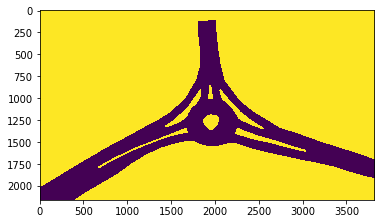

In [6]:
knn_fill_empty(img, 25)
plt.imshow(img)

### Show example of  color image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


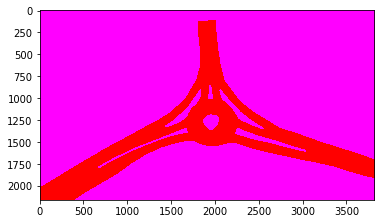

In [7]:
color_img = convert_to_color_img(img)
plt.imshow(color_img)